In [1]:
import numpy as np
import numpy.matlib as npm

import scipy
import scipy.stats # for multivariate_normal
import scipy.io # Need this to load .mat files

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from cycler import cycler

# Data set that Keene asked us to generate in class
def getKeeneData(N1, N2):
    
    # Total number of observations
    N = N1+N2;

    # Parameters for Gaussian (these are unknown and we're to estimate them)
    mu1 = np.array([2,2])
    mu2 = np.array([-2,-2])
    cov = np.array([[1,0],[0,1]]) # or do identity

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X1 = np.random.multivariate_normal(mu1,cov,N1)
    X2 = np.random.multivariate_normal(mu2,cov,N2)                               
    X = np.concatenate((X1,X2),axis=0)
        # concatenate data into one matrix
    Y = np.concatenate(( np.ones((X1.shape[0],1)), \
                        np.zeros((X2.shape[0],1)) ),axis=0)
        # generate column vector for corresponding values (we want to predict these)

    # Convert data to matrices for simpler Python operations
    X = np.asmatrix(X)
    Y = np.asmatrix(Y)
    
    return (X,Y)

def getSpecialData():
    
    mat = scipy.io.loadmat('data.mat')
    
    X_circles = np.asmatrix(mat['circles'][0][0][0])
    Y_circles = np.asmatrix(mat['circles'][0][0][1])

    X_unimodal = np.asmatrix(mat['unimodal'][0][0][0])
    Y_unimodal = np.asmatrix(mat['unimodal'][0][0][1])
    
    X_spiral = np.asmatrix(mat['spiral'][0][0][0])
    Y_spiral = np.asmatrix(mat['spiral'][0][0][1])
    
    X_bimodal = np.asmatrix(mat['bimodal'][0][0][0])
    Y_bimodal = np.asmatrix(mat['bimodal'][0][0][1])
    
    return (X_circles,Y_circles,X_unimodal,Y_unimodal,X_spiral,Y_spiral,X_bimodal,Y_bimodal)

# Generate randomly clustered data, 2 features
# Specify K (number of clusters), sizes of clusters as a list, r (distance between clusters),
def generateClusters(K,sizes,r=3):
    
    if K > len(sizes):
        print('Specified K %d exceeds size of list %d' % (K, len(sizes)))
        return
    
    # Parameters to generate data with using for Gaussian
    mu = []
    for k in range(K):
        # Specify position of means in polar coordinates first, then go back to Cartesian
        # This is so we can evenly divide clusters
        theta = 2*np.pi*k/float(K)
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        mu.append(np.array([x,y]))
    cov = np.eye(2) # just use identity for all covariances

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X = np.empty((0,2)) # zero rows so that there are no initial values
    for k in range(K):       
        X_k = np.random.multivariate_normal(mu[k],cov,sizes[k])
        X = np.concatenate((X,X_k),axis=0) # concatenate rows together
 
    # Convert data to matrices for simpler Python operations
    X = np.asmatrix(X)

    return X

# Plot original data with mean and standard deviation contours around mean
# Only works for 2 features
def plotContours(X, mu, cov):
    
    # Don't plot if not 2 features
    M = X.shape[1]
    if M != 2:
        return
    
    figsize = (8,6)
    
    # Set figure size and get plot axes
    plt.figure(figsize=figsize)
    axes = plt.gca()
    #plt.subplot(1,2,1)

    # Plot data
    plt.scatter(X[:,0],X[:,1],color='r')
    
    # Plot each mean
    for k in range(len(mu)):
        plt.scatter(mu[k][0],mu[k][1],color='k')
    
    # One contour plot for each mean
    n1 = 100
    n2 = 100
    x1 = np.linspace(-10,10,n1)
    x2 = np.linspace(-10,10,n2)
    X1, X2 = np.meshgrid(x1,x2)
    for k in range(len(mu)):
        # Combine X1 and X2 into one matrix with two features (unroll them first) before putting in normal
        # When combining the two raveled matrices, don't use concatenate, because ravel makes it so it's 1D, so result of concat is 1D
        #print np.array([np.ravel(X1), np.ravel(X2)])
        #print np.concatenate((np.ravel(X1),np.ravel(X2)),axis=0)
        normpdf = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
        temp = np.array([np.ravel(X1), np.ravel(X2)])
        z = []
        for i in range(n1*n2):
            z.append(normpdf.pdf(np.ravel(temp[:,i])))
        # Reshape z to have the same dimensions as meshgrid for plot
        # NOTE: reshape can be applied to lists and still return an ndarray
        z = np.reshape(z,(n1,n2))
        plt.contour(x1,x2,z)
    
    # Plot labels
    plt.title('Observations and K-Means (Contour Plot)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
# Plot original data with colors corresponding to responsibility values
# Also plot the contour for one standard deviation away from mean
# Only works for 2 features
# Only works for 2 <= K <= 3
def plotColors(X, mu, cov, K, gamma):
    
    # Don't plot if not 2 features
    M = X.shape[1]
    if M != 2:
        return
    
    # Don't plot if K isn't 2 or 3
    if K > 3 or K < 2:
        return
    
    figsize = (8,6)
    
    # Set figure size and get plot axes
    plt.figure(figsize=figsize)
    axes = plt.gca()
    #plt.subplot(1,2,2)

    # Plot color-coded data
    N = X.shape[0]
    for n in range(N):
        r = gamma[0][n,0] # red is k = 1
        g = gamma[1][n,0] # green is k = 2
        if K == 2:
            b = 0 # fix one of the RGB values if only 2 clusters
        elif K == 3:
            b = gamma[2][n,0] # blue is k = 3
        plt.scatter(X[n,0],X[n,1],color=(r,g,b))
        
    # One contour plot for each mean
    n1 = 100
    n2 = 100
    x1 = np.linspace(-10,10,n1)
    x2 = np.linspace(-10,10,n2)
    X1, X2 = np.meshgrid(x1,x2)
    for k in range(K):
        # Combine X1 and X2 into one matrix with two features (unroll them first) before putting in normal
        # When combining the two raveled matrices, don't use concatenate, because ravel makes it so it's 1D, so result of concat is 1D
        #print np.array([np.ravel(X1), np.ravel(X2)])
        #print np.concatenate((np.ravel(X1),np.ravel(X2)),axis=0)
        normpdf = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
        temp = np.array([np.ravel(X1), np.ravel(X2)])
        z = []
        for i in range(n1*n2):
            z.append(normpdf.pdf(np.ravel(temp[:,i])))
        # Reshape z to have the same dimensions as meshgrid for plot
        # NOTE: reshape can be applied to lists and still return an ndarray
        z = np.reshape(z,(n1,n2))
        # Only want to plot points that are one std. dev away
        rgb = 'r' if (k == 0) else ('g' if (k == 1) else 'b');
        plt.contour(x1,x2,z,1,colors=rgb)
    
    # Plot each mean
    for k in range(K):
        plt.scatter(mu[k][0],mu[k][1],color='k')
    
    # Plot labels
    plt.title('Observations and K-Means (Color Plot)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


N: 150 M: 2

Before EM:


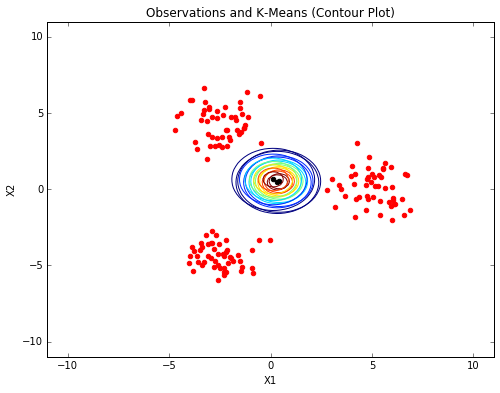

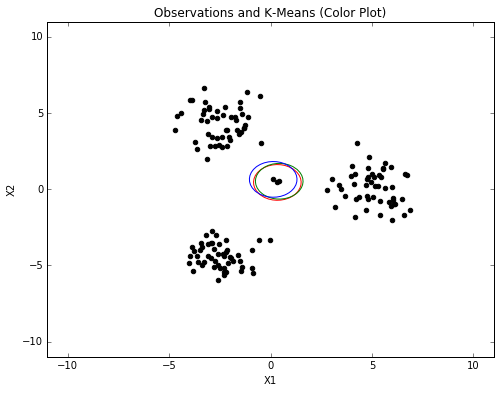

Iteration 1:
Log likelihood: -2333.81070373


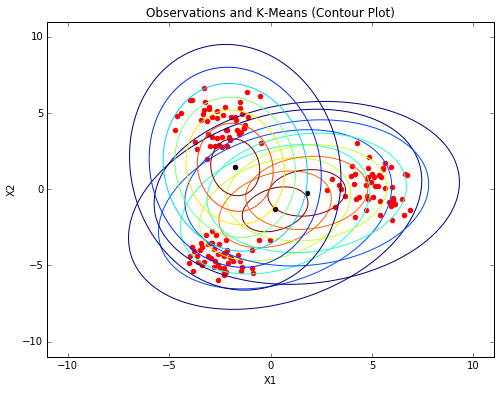

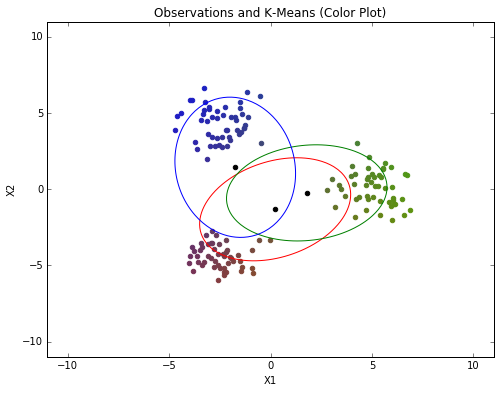


Iteration 2:
Log likelihood: -800.902095577


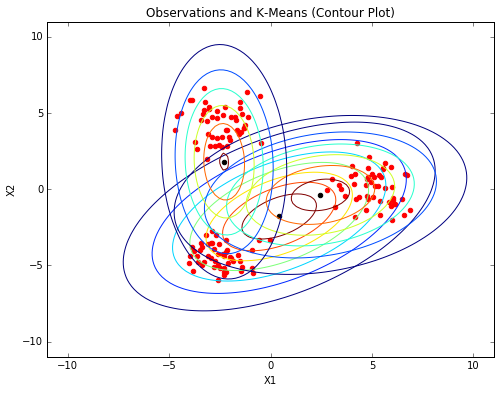

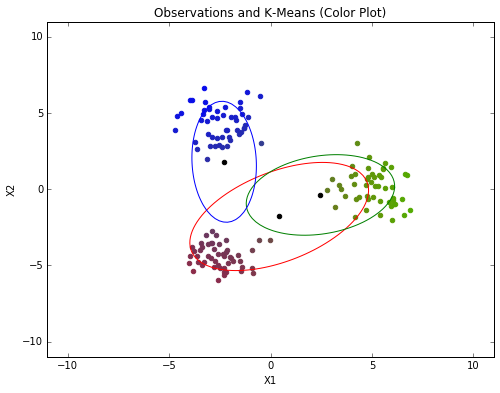


Iteration 3:
Log likelihood: -765.737356493


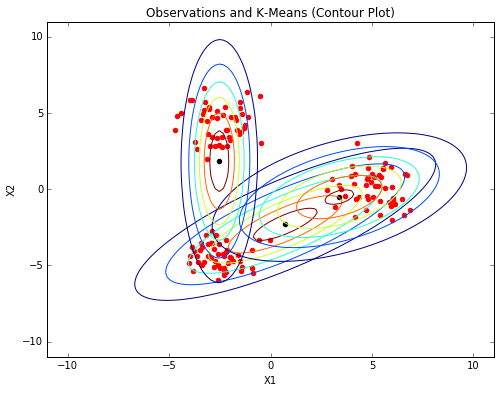

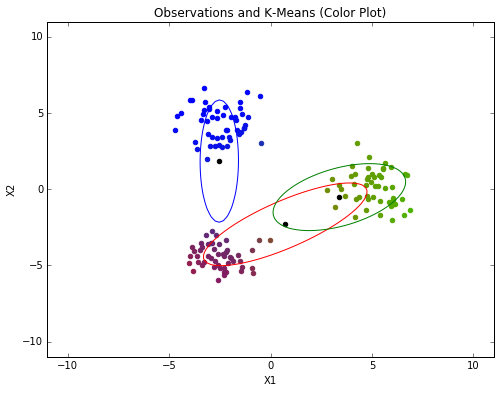


Iteration 4:
Log likelihood: -720.108620546


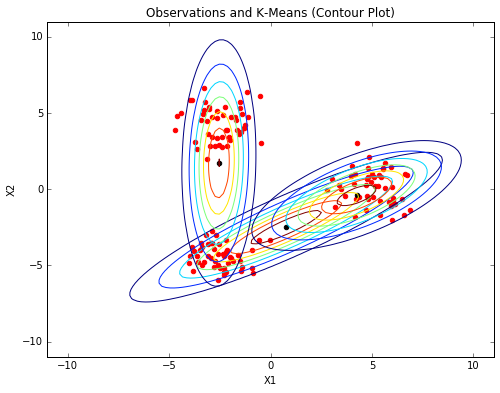

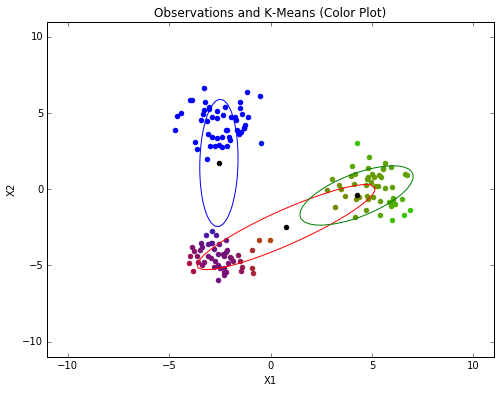


Iteration 5:
Log likelihood: -702.475682662


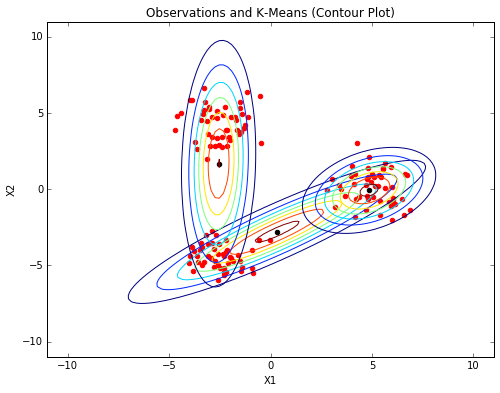

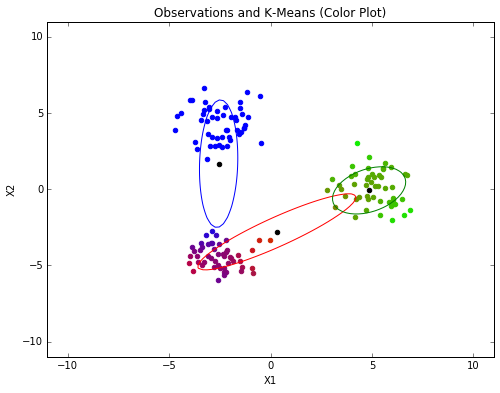


Iteration 6:
Log likelihood: -684.965199076


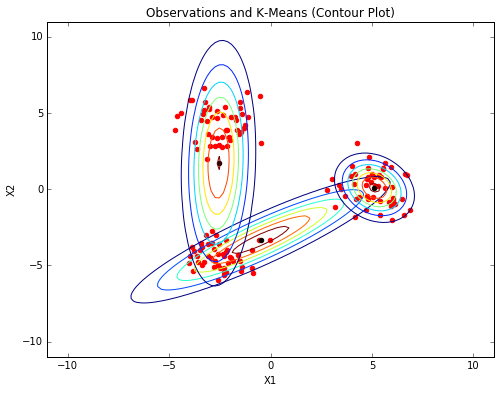

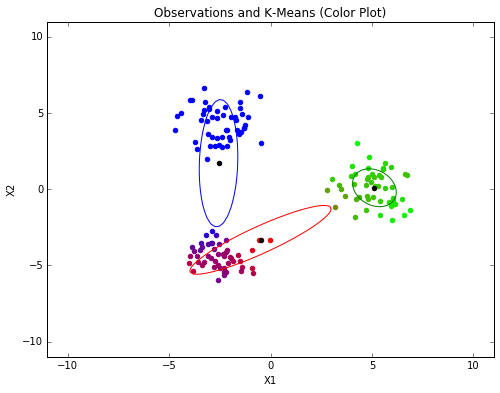


Iteration 7:
Log likelihood: -665.785827971


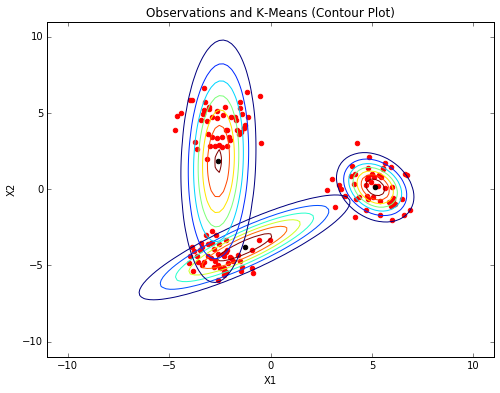

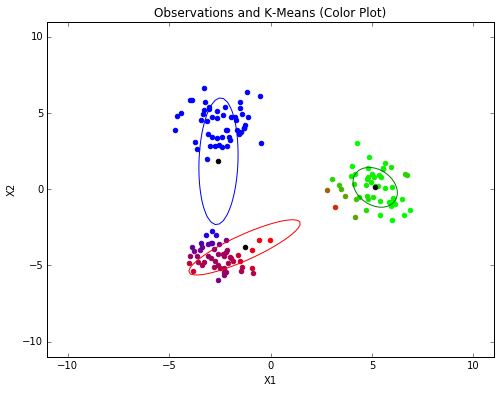


Iteration 8:
Log likelihood: -659.989415798


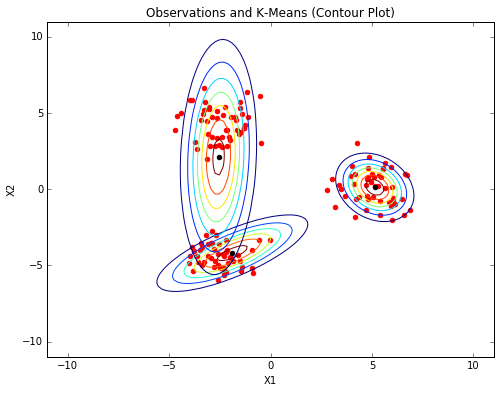

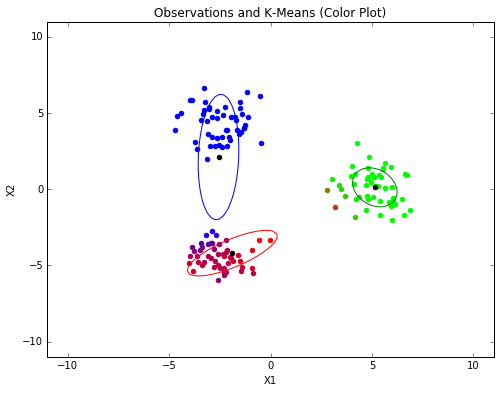


Iteration 9:
Log likelihood: -648.982947542


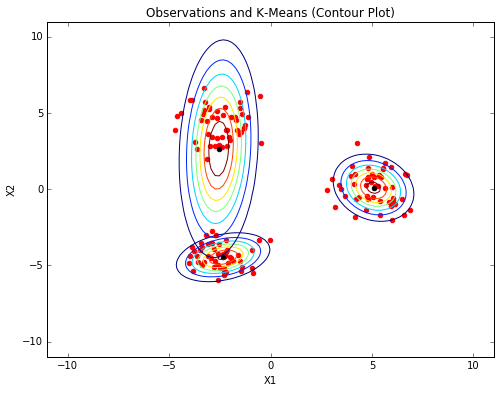

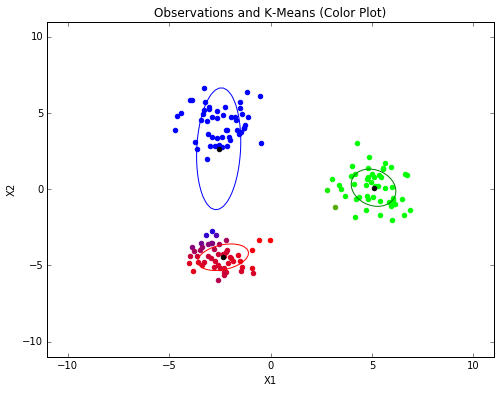


Iteration 10:
Log likelihood: -624.077847275


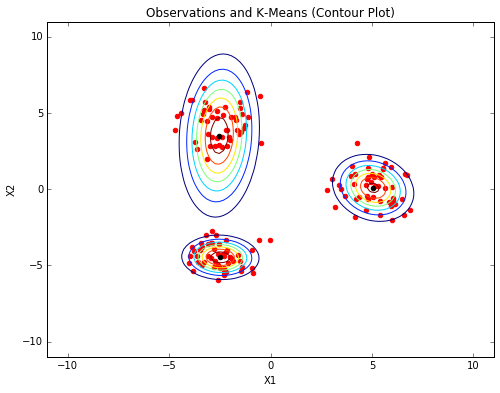

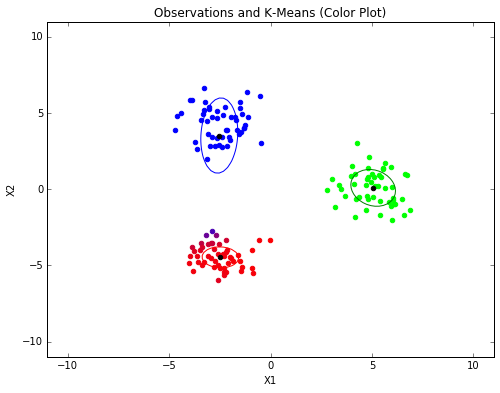


Iteration 11:
Log likelihood: -606.314559127


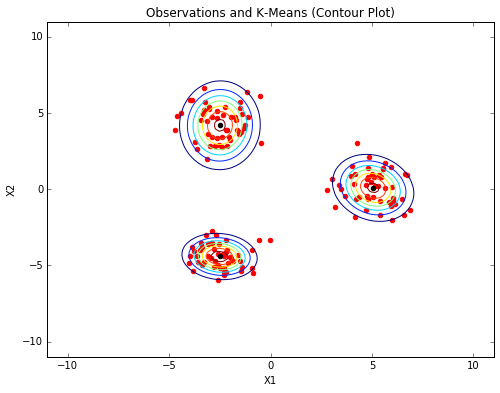

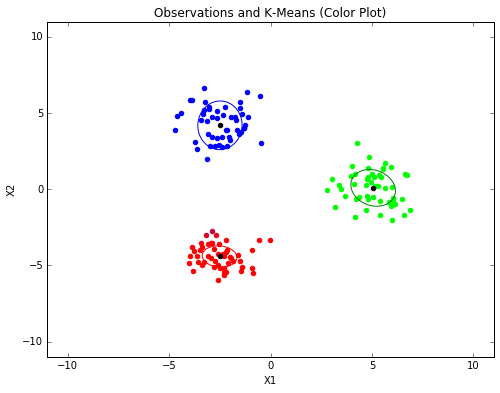


K-Means converged on iteration 11, parameters converged.
Displaying log likelihoods: (old=-624.07785,new=-606.31456,diff=17.76329)


In [2]:
# Perform Expectation-Maximization on a given observation set X
# Specify K, the number of clusters
# X is an N-by-M matrix
def EM(X, K=2):
    
    """
    # Step 1: Initialize parameters
    # u_k is M-by-1, cov_k is M-by-M, pi_k is scalar
    for k in range(K):
        # sum_n(gamma_n*x_n) is equivalent to gamma*X
        # gamma is N-by-1, X is N-by-M
        # To get M-by-1, do X.T*gamma
        mu_k = sum(X.T*gamma,axis=1)/float(N_k)
        # gamma is N-by-1, X is N-by-M, X.T is M-by-N
        # To get M-by-M, do X.T*X*
        cov_k = sum(/N_k
    """
    
    # N observations, M features
    N = X.shape[0]
    M = X.shape[1]
    
    print "N:", N, "M:", M
    print
    print "Before EM:"
    
    # Step 1: Initialize parameters and log-likelihood
    
    # Initialize containers for parameters
    # mu_k is M-by-1 => mu is k-by-M-by-1
    # cov_k is M-by-M => cov is k-by-M-by-M
    # pi_k is 1-by-1 => pi is k-by-1-by-1
    # Just use k-dim lists
    #mu = [npm.zeros((M,1)) for k in range(K)]
        # mu's can't be the same for both K because then normpdf will be the same for both
        # then nothing will change because responsibility is always equal to pi (denom is the same as numerator without pi)
    #mu = [np.matrix([2,-2]).T,np.matrix([-2,2]).T]
        # works, but don't want to hard code
    mu = [np.asmatrix(np.random.rand(M,1)) for k in range(K)]
    cov = [npm.eye(M) for k in range(K)]
    pi = [float(1)/K for k in range(K)] # can't initialize to 0 or denom will be 0
    
    # Initialize log-likelihood
    log_likelihood = 0
    
    # Initialize responsibilities to zero, N responsibilities for each k
    # gamma_k is N-by-1
    gamma = [npm.zeros((N,1)) for k in range(K)]
    
    # Initialize Nk's
    Nk = [0 for k in range(K)]
    
    #print mu[0]
    #print cov[0]
    #print pi[0]
    
    plotContours(X,mu,cov)
    plotColors(X,mu,cov,K,gamma)
    
    # Repeat steps 2 to 4 until convergence
    iterations = 100
    for iteration in range(iterations):
        
        # NOTE: Need to reset values to 0 before doing ANY summation
        
        # Compute the frozen multivariate normal for current mu, cov before doing anything else
        # This may save some computation time
        # Use np.ravel to make mean array-like (doesn't deal with column matrices)
        normpdf = [0 for k in range(K)]
        for k in range(K):
            normpdf[k] = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
    
        # Step 2: E step, update responsibilities
        for k in range(K):
            for n in range(N):

                # Compute denominator of responsibility
                denom = 0
                for j in range(K):
                    denom += pi[j]*normpdf[j].pdf(np.ravel(X[n,:]))
                    #print 'normpdf_j', normpdf[j].pdf(np.ravel(X[n,:]))
                
                #print 'denom', denom
                
                # Needed to call multivariate_normal without x as input to freeze the distribution
                # Now get the associated probability using pdf, use np.ravel again to avoid issues with input
                gamma[k][n,0] = pi[k]*normpdf[k].pdf(np.ravel(X[n,:]))/denom
                
                #print 'normpdf', normpdf[k].pdf(np.ravel(X[n,:]))
                #print 'k =', k, 'n =', n, 'gamma[k][n] =', gamma[k][n,0]
                
        # Need to update Nk's after responsibilities are calculated
        for k in range(K):
            Nk[k] = 0
            for n in range(N):
                Nk[k] += gamma[k][n,0]
        
        # Step 3: M step, update parameters using new responsibilities
        # X[n,:] is 1-by-M, so transpose for M-by-1

        # Update mu
        mu_old = list(mu) # need to make a copy using list(), assignment copies the list reference, not the list itself
        for k in range(K):
            mu[k] = npm.zeros((M,1))
            for n in range(N):
                # Need to index into 2nd dim as well to get scalar (1x1 times Mx1 doesn't work)
                mu[k] += gamma[k][n,0]*X[n,:].T/float(Nk[k])
        
        # Update cov, new mu_k's to update cov_k's
        cov_old = list(cov)
        for k in range(K):
            cov[k] = npm.zeros((M,M))
            for n in range(N):
                cov[k] += gamma[k][n,0]*(X[n,:].T-mu[k])*(X[n,:].T-mu[k]).T/float(Nk[k])
         
        # Update pi
        pi_old = list(pi)
        for k in range(K):
            pi[k] = Nk[k]/float(N)
                    
        # Step 4: Evaluate log likelihood
        log_likelihood_old = log_likelihood
        log_likelihood = 0
        for n in range(N):
            temp = 0;
            for k in range(K):
                temp += pi[k]*normpdf[k].pdf(np.ravel(X[n,:]))
            log_likelihood += np.log(temp)
        
        # Print stas
        print ("Iteration %d:" % (iteration+1))
        #print "Responsibility:", gamma
        #print "Nk:", Nk
        #print "mu:", mu
        #print "cov:", cov
        #print "pi:", pi
        print "Log likelihood:", log_likelihood
        plotContours(X,mu,cov)
        plotColors(X,mu,cov,K,gamma)
        print
        
        # Convergence test, break if either parameters or log likelihood converge
        
        if abs(log_likelihood-log_likelihood_old) < 0.001:
            print ("K-Means converged on iteration %d, log likelihood converged (old=%.5f,new=%.5f,diff=%.5f)." \
                       % (iteration+1,log_likelihood_old,log_likelihood,abs(log_likelihood-log_likelihood_old)))
            break
            
        break_EM = False
        for k in range(K):
            if np.linalg.norm(mu[k]-mu_old[k],ord=2) < 0.001 or \
                np.linalg.norm(cov[k]-cov_old[k],ord=2) < 0.001:# or \
                #abs(pi[k]-pi[k]) < 0.001: # ignore this for now because pi is initialized to be the same
                    print ("K-Means converged on iteration %d, parameters converged.\nDisplaying log likelihoods: (old=%.5f,new=%.5f,diff=%.5f)" \
                           % (iteration+1,log_likelihood_old,log_likelihood,abs(log_likelihood-log_likelihood_old)))
                    break_EM = True
                    break

        if break_EM:
            break
            
        #if iteration == 1:
        #    break
        
    return gamma, mu, cov, pi, log_likelihood

#X = npm.ones((5,3))
#(X_circles,Y_circles,X,Y_unimodal,X_spiral,Y_spiral,X_bimodal,Y_bimodal) = getSpecialData()
#(X,Y) = getKeeneData(50,50)
#EM(X,K=2) 

K=3
X = generateClusters(K,[50,50,50,50,50],r=5)
(gamma,mu,cov,pi,log_likelihood) = EM(X,K=K)  